In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

print('Physical Devices:')
for dev in tf.config.list_physical_devices():
    print(dev)

Physical Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [3]:
from zscomm.agent import Agent
from zscomm.comm_channel import CommChannel
from zscomm.synth_teacher import SyntheticTeacher
from zscomm.data import *
from zscomm.play_game import *
from zscomm.loss import *
from zscomm.experiment import Experiment
from zscomm.plot_game import plot_game
from zscomm.analysis import *

## Check that gradients can flow across channel:

In [4]:
channel = CommChannel(size=10, temperature=10, one_hot=True)

x = tf.Variable([[-1, 2, 4, 0]], dtype=tf.float32)
with tf.GradientTape() as tape:
    y = channel(x, training=True)
    
print(y)
tape.gradient(y, x)

tf.Tensor([[0.20920765 0.2818462  0.3159615  0.19298464]], shape=(1, 4), dtype=float32)


<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0., 0., 0., 0.]], dtype=float32)>

In [5]:
channel(x)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

## Load Data:

In [6]:
NUM_CLASSES = 3
BATCH_SIZE = 32
USE_MNIST = False

if USE_MNIST:
    TRAIN_DATA, TEST_DATA = get_mnist_data(num_classes=NUM_CLASSES)
else:
    TRAIN_DATA, TEST_DATA = get_simple_card_data(num_classes=NUM_CLASSES)

In [7]:
def generate_train_batch():
    return generate_batch(TRAIN_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)


def generate_test_batch():
    return generate_batch(TEST_DATA,
                          batch_size=BATCH_SIZE, 
                          num_classes=NUM_CLASSES)

In [8]:
inputs, targets = generate_train_batch()

In [9]:
tf.shape(inputs), tf.shape(targets)

(<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  2])>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 4, 32,  3])>)

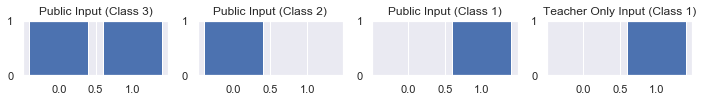

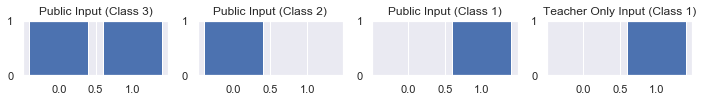

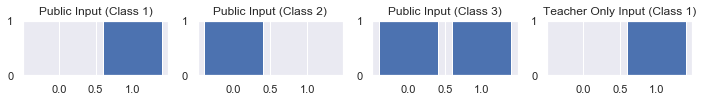

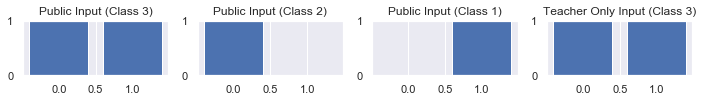

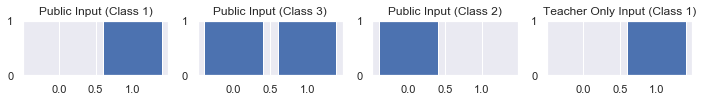

In [10]:
class_labels = list(TRAIN_DATA.keys())

if USE_MNIST:
    figsize = (10, 10*(1 + len(class_labels)))
else:
    figsize = (3*(1 + len(class_labels)), 1)

select_batch = 0
show_rows = 5

for row in range(show_rows):
    fig, axs = plt.subplots(1, len(class_labels) + 1, 
                            figsize=figsize)
    for i, (ax, inp, tar) in enumerate(zip(axs, inputs, targets)):
        l = tar[row].numpy().argmax() + 1
        if i < NUM_CLASSES:
            ax.set_title(f'Public Input (Class {l})')
        else:
            ax.set_title(f'Teacher Only Input (Class {l})')
        if USE_MNIST:
            img = inp[row].numpy()
            ax.imshow(img)
            ax.axis('off')
        else:
            domain = list(range(len(inp[row])))
            ax.bar(domain, inp[row])
            ax.set_ylim([0, 1])
            ax.set_yticks([0, 1])
    plt.show()

In [11]:
history = []
comm_channel = CommChannel(size=5, temperature=1, noise=0.5)

msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), history, 1)
history.append({'message_from_teacher': msg})
msg, _ = maybe_mutate_message(comm_channel.get_initial_state(5), history, 1)
history.append({'message_from_teacher': msg})
tf.transpose([
    tf.argmax(item['message_from_teacher'], axis=-1) 
    for item in history
])

<tf.Tensor: shape=(5, 4), dtype=int64, numpy=
array([[3, 0, 4, 1],
       [3, 2, 4, 0],
       [1, 3, 0, 2],
       [2, 3, 1, 0],
       [4, 0, 3, 1]], dtype=int64)>

## Create Data-Specific Input Encoder

In [12]:
if USE_MNIST:
    encoder_latent_dim = 64
    _, *img_shape = x_train.shape
    AGENT_INPUT_ENCODER = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=img_shape),
            tf.keras.layers.Reshape(target_shape=(*img_shape, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(encoder_latent_dim),
        ]
    )

else: 
    AGENT_INPUT_ENCODER = None

CHANNEL_SIZE = 5

### Checking Gradients of Agent Parameters with Respect to Loss Function:

In [13]:
teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
# teacher = experiment.teacher
# student = experiment.student

inputs, targets = generate_train_batch()

with tf.GradientTape(persistent=True) as tape:
    outputs = play_game(inputs, teacher, student,
                        training=True,
                        channel_size=CHANNEL_SIZE,
                        p_mutate=0.5)

    loss = complete_loss_fn(outputs, targets)
#     loss = protocol_diversity_loss(outputs)
#     loss = protocol_entropy(outputs)

teacher_grads = tape.gradient(loss, teacher.trainable_variables)
student_grads = tape.gradient(loss, student.trainable_variables)

print('Mean Loss:', loss.numpy().mean())

print()

for v, g in zip(teacher.trainable_variables, teacher_grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5}')

print()

for v, g in zip(student.trainable_variables, student_grads):
    print(f'{v.name} student grad norm: {tf.reduce_sum(g**2)**0.5}')

Instructions for updating:
Use tf.identity instead.
Mean Loss: 3.9396443

agent/dense/kernel:0 teacher grad norm: 2.13630747795105
agent/dense/bias:0 teacher grad norm: 1.4631658792495728
agent/lstm/kernel:0 teacher grad norm: 3.8009591102600098
agent/lstm/recurrent_kernel:0 teacher grad norm: 0.8118849396705627
agent/lstm/bias:0 teacher grad norm: 1.8294881582260132
agent/dense_1/kernel:0 teacher grad norm: 1.6857293844223022
agent/dense_1/bias:0 teacher grad norm: 2.5933680534362793

agent/dense_2/kernel:0 student grad norm: 1.346722960472107
agent/dense_2/bias:0 student grad norm: 1.4531991481781006
agent/lstm_1/kernel:0 student grad norm: 2.0920400619506836
agent/lstm_1/recurrent_kernel:0 student grad norm: 0.6527954936027527
agent/lstm_1/bias:0 student grad norm: 1.5562529563903809
agent/dense_3/kernel:0 student grad norm: 0.9311153888702393
agent/dense_3/bias:0 student grad norm: 1.7913753986358643


In [14]:
complete_loss_fn(outputs, targets)

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([4.1314   , 3.8894305, 4.2500486, 3.822261 , 3.9415987, 3.7790132,
       4.0057898, 4.197577 , 3.7853966, 4.345298 , 4.0906124, 4.0321007,
       4.4365177, 3.6201406, 3.602316 , 3.895419 , 3.554259 , 3.5403419,
       3.8077083, 4.0081916, 3.5868914, 4.1307306, 4.1746974, 3.9447203,
       3.8138502, 4.1134467, 3.7352324, 4.1586623, 3.9921842, 3.6388004,
       3.587037 , 4.4569416], dtype=float32)>

In [15]:
teacher.summary()

Model: "agent"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1664      
_________________________________________________________________
lstm (LSTM)                  multiple                  49408     
_________________________________________________________________
dense_1 (Dense)              multiple                  520       
_________________________________________________________________
lambda_1 (Lambda)            multiple                  0     

In [16]:
inputs, targets = generate_train_batch()
outputs = play_game(inputs, teacher, student,
                    p_mutate=1, 
                    channel_size=CHANNEL_SIZE,
                    kind_mutations=False,
                    training=False)

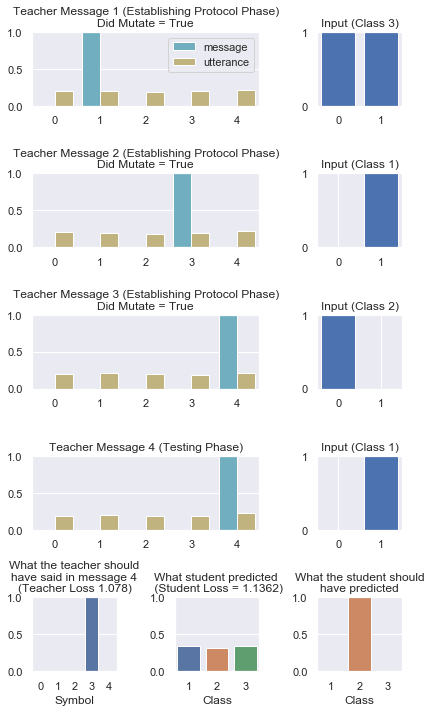

In [17]:
plot_game(inputs, outputs, targets, select_batch=6)

In [18]:
inputs, targets = generate_train_batch()

import unittest.mock as mock
synth_student = mock.MagicMock(return_value=(None, None, None))


with tf.GradientTape(persistent=True) as tape:
    outputs = play_game(inputs, teacher, synth_student, 
                        training=True, 
                        stop_gradients_on_all_comm=False,
                        channel_size=CHANNEL_SIZE,
                        p_mutate=0)

    loss = protocol_diversity_loss(outputs)

teacher_grads = tape.gradient(loss, teacher.trainable_variables)

for v, g in zip(teacher.trainable_variables, teacher_grads):
    print(f'{v.name} teacher grad norm: {tf.reduce_sum(g**2)**0.5}')

agent/dense/kernel:0 teacher grad norm: 1.9063971042633057
agent/dense/bias:0 teacher grad norm: 1.8990148305892944
agent/lstm/kernel:0 teacher grad norm: 3.0303919315338135
agent/lstm/recurrent_kernel:0 teacher grad norm: 0.28824377059936523
agent/lstm/bias:0 teacher grad norm: 2.1875927448272705
agent/dense_1/kernel:0 teacher grad norm: 1.2219854593276978
agent/dense_1/bias:0 teacher grad norm: 4.170324802398682


# Run Experiments

In [28]:
def create_only_student_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 1, 
        'stop_gradients_on_all_comm': True
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        teacher=agent,
        loss_fn=teacher_test_message_is_correct,
        name='only_student_experiment'
    )


def create_only_teacher_test_msg_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 1, 
        'stop_gradients_on_all_comm': True
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        loss_fn=student_pred_matches_implied_class,
        name='only_teacher_test_msg_experiment'
    )


def create_only_teacher_create_protocol_experiment():
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 0
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        teacher=agent,
        loss_fn=lambda o, t: protocol_diversity_loss(o),
        name='only_teacher_create_protocol_experiment'
    )

def create_other_play_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': p_mutate
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        loss_fn=complete_loss_fn,
        name='other_play_experiment'
    )

def create_other_play_separate_optimise_experiment(p_mutate=0.3):
    
    student = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)
    teacher = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': p_mutate
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=student,
        teacher=teacher,
        student_loss_fn=student_pred_matches_implied_class,
        teacher_loss_fn=student_pred_matches_test_class,
        name='other_play_separate_optimise_experiment'
    )

def create_self_play_experiment(p_mutate=0.3, epochs=40):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': p_mutate
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        max_epochs=epochs,
        name='self_play_experiment'
    )

def create_mutation_with_temp_annealing_experiment(
    p_mutate=0.3, channel_size=5, epochs=100, **exp_kwargs
):
    agent = Agent(channel_size, NUM_CLASSES)

    start_temp = 10
    end_temp = 1.0
    temp_anneal_end_epoch = 50
    a = -np.log(end_temp / start_temp) / temp_anneal_end_epoch
    
    def play_params(epoch):
        if epoch < temp_anneal_end_epoch:
            channel_temp = float(start_temp * np.exp(-a*epoch))
        else:
            channel_temp = end_temp
        
        return {
            'channel_size': CHANNEL_SIZE,
            'p_mutate': p_mutate,
            'channel_temp': channel_temp,
        }
    
    def loss_fn(o, t):
        return combined_loss_fn(o, t, w=0.5)
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=loss_fn,
        max_epochs=epochs,
        lr=1e-2,
        step_print_freq=10,
        **exp_kwargs
    )

def create_mut_temp_direct_loss_experiment(
    p_mutate=0.3, channel_size=5, epochs=250, **exp_kwargs
):
    agent = Agent(channel_size, NUM_CLASSES)

    start_temp = 10
    end_temp = 1.0
    temp_anneal_end_epoch = 50
    a = -np.log(end_temp / start_temp) / temp_anneal_end_epoch
    
    def play_params(epoch):
        if epoch < temp_anneal_end_epoch:
            channel_temp = float(start_temp * np.exp(-a*epoch))
        else:
            channel_temp = end_temp
        
        return {
            'channel_size': CHANNEL_SIZE,
            'p_mutate': p_mutate,
            'channel_temp': channel_temp,
#             'stop_gradients_on_final_message': True,
        }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=student_pred_matches_test_class,
        max_epochs=epochs,
        lr=1e-2,
        step_print_freq=10,
        **exp_kwargs
    )

def create_message_permutation_experiment(epochs=40):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 0,
        'message_permutation': True,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=complete_loss_fn,
        max_epochs=epochs,
        name='message_permutation_experiment'
    )

def create_message_permutation_is_all_you_need_experiment(epochs=100):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    play_params =  {
        'channel_size': CHANNEL_SIZE,
        'p_mutate': 0,
        'message_permutation': True,
    }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=student_pred_matches_test_class,
        max_epochs=epochs,
        lr=1e-2,
        name='message_permutation_is_all_you_need'
    )

def create_channel_subset_permutation_experiment(subset_size=3, epochs=100):
    
    agent = Agent(CHANNEL_SIZE, NUM_CLASSES, encoder=AGENT_INPUT_ENCODER)

    start_temp = 10
    end_temp = 0.1
    temp_anneal_end_epoch = 200
    a = -np.log(end_temp / start_temp) / temp_anneal_end_epoch
    
    def play_params(epoch):
        if epoch < temp_anneal_end_epoch:
            channel_temp = float(start_temp * np.exp(-a*epoch))
        else:
            channel_temp = end_temp
        
        return {
            'channel_size': CHANNEL_SIZE,
            'p_mutate': 0,
            'message_permutation': True,
            'permutation_subset_size': subset_size,
            'channel_temp': channel_temp,
        }
    
    return Experiment(
        generate_train_batch, generate_test_batch,
        play_params=play_params, 
        student=agent,
        teacher=agent,
        loss_fn=student_pred_matches_test_class,
        max_epochs=epochs,
        lr=1e-2,
        name='channel_subset_permutation'
    )

In [23]:
mutation_temp_anneal_exp = create_mutation_with_temp_annealing_experiment()

In [23]:
mutation_temp_anneal_exp.max_epochs = 150

In [ ]:
mutation_temp_anneal_exp.run()

In [ ]:
msg_mut_exp = create_self_play_experiment()

In [ ]:
msg_mut_exp.run()

In [ ]:
exp = mutation_temp_anneal_exp
games_played, test_metrics = exp.run_tests()
test_metrics, exp.get_config()

In [29]:
subset_permutation_exp = create_channel_subset_permutation_experiment(epochs=200)

In [36]:
subset_permutation_exp.run()

Running channel_subset_permutation...
Run config:
 {'name': 'channel_subset_permutation', 'max_epochs': 200, 'steps_per_epoch': 50, 'epochs_optimised': 200, 'play_params': {'channel_size': 5, 'p_mutate': 0, 'message_permutation': True, 'permutation_subset_size': 3, 'channel_temp': 0.1}, 'test_freq': 5, 'test_steps': 25, 'optimiser_config': {'name': 'RMSprop', 'learning_rate': 0.009999999776482582, 'decay': 0.0, 'rho': 0.8999999761581421, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}, 'optimise_agents_separately': False, 'loss_fn': 'student_pred_matches_test_class'}
Epoch 0, Time Taken (mm:ss): 0:22, Mean Loss: 1.107
Test Loss: 1.103, Ground Truth F1-Score: 0.324, Student Error: 1.101, Teacher Error: 1.476, Protocol Diversity: 0.665, Protocol Entropy: 0.14,
Epoch 1, Time Taken (mm:ss): 0:15, Mean Loss: 0.86
Epoch 2, Time Taken (mm:ss): 0:16, Mean Loss: 0.29
Epoch 3, Time Taken (mm:ss): 0:18, Mean Loss: 0.04
Epoch 4, Time Taken (mm:ss): 0:24, Mean Loss: 0.017
Epoch 5, Time Taken 

In [ ]:
permutation_experiment = create_message_permutation_is_all_you_need_experiment(epochs=200)

In [ ]:
permutation_experiment.run()

In [37]:
games_played, test_metrics = subset_permutation_exp.run_tests()

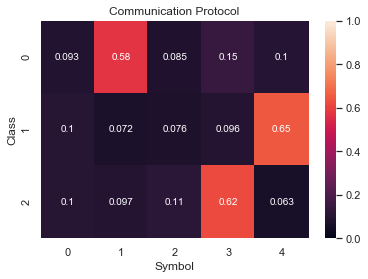

In [38]:
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1, annot=True);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

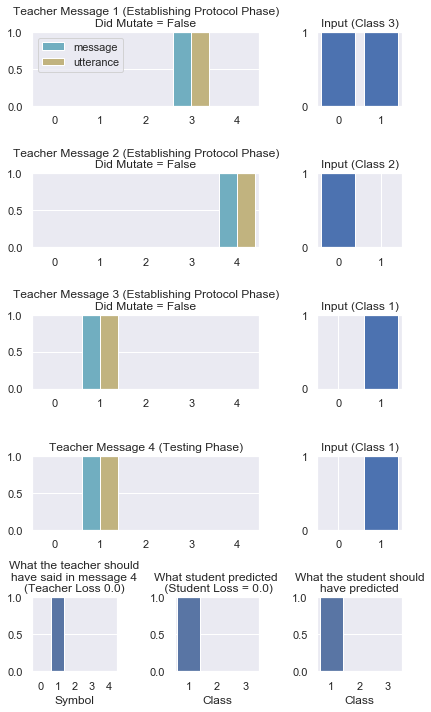

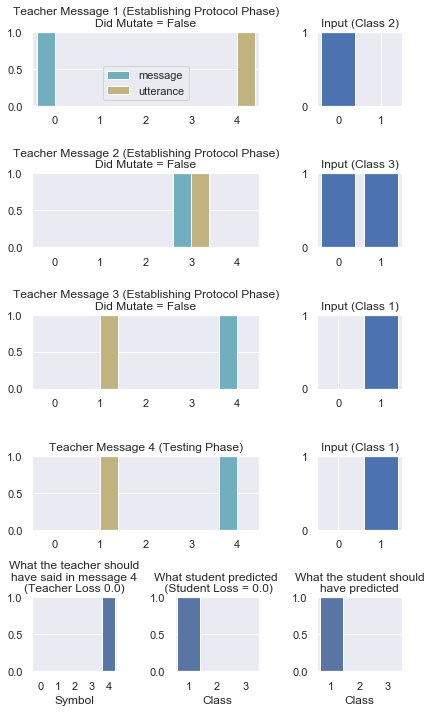

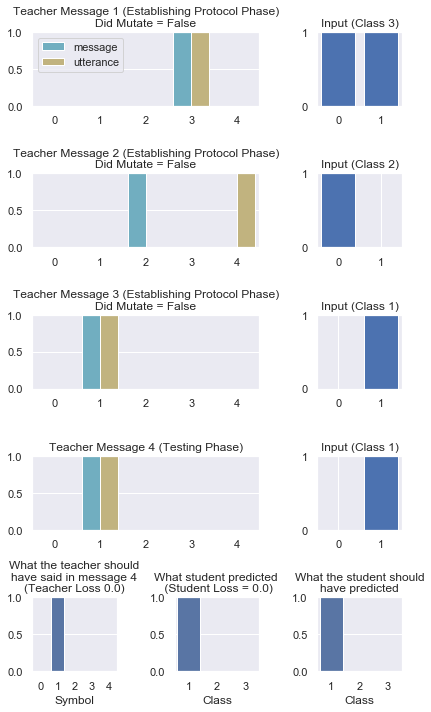

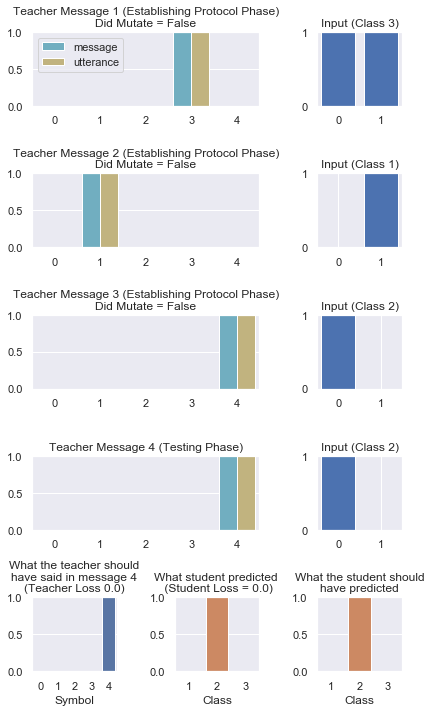

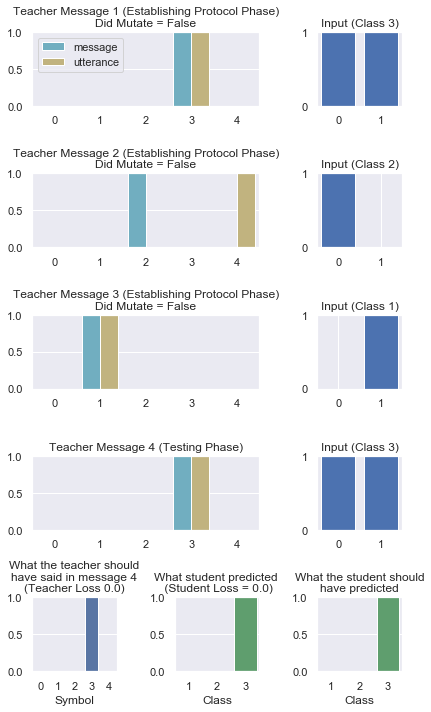

In [39]:
for i in range(5):
    inputs, targets, outputs = games_played[5+i]
    plot_game(inputs, outputs, targets, select_batch=1)

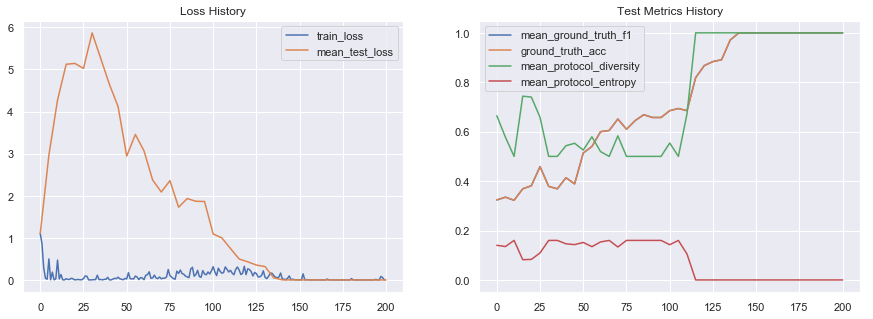

In [40]:
exp = subset_permutation_exp
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax = axs[0]
ax.set_title('Loss History')
ax = axs[1]
ax.set_title('Test Metrics History')

ax = axs[0]
sns.lineplot(x=range(len(exp.training_history)), 
             y=[item['loss'] for item in exp.training_history],
             label='train_loss',
             ax=ax);

test_metric_items = [
    item['test_metrics'] 
    for item in exp.training_history
    if 'test_metrics' in item
]
epochs = [
    epoch * exp.test_freq 
    for epoch, item in enumerate(test_metric_items)
]
metrics = list(test_metric_items[0].keys())

for metric in metrics:
    if 'error' in metric:
        continue
    ax = axs[1] if metric != 'mean_test_loss' else axs[0]
    sns.lineplot(x=epochs, 
                 y=[item[metric] for item in test_metric_items],
                 label=metric,
                 ax=ax)

In [41]:
import zscomm.loss as losses

In [42]:
losses.__dict__

{'__name__': 'zscomm.loss',
 '__doc__': None,
 '__package__': 'zscomm',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x1f53ee3f710>,
 '__spec__': ModuleSpec(name='zscomm.loss', loader=<_frozen_importlib_external.SourceFileLoader object at 0x000001F53EE3F710>, origin='C:\\Users\\dylan\\OneDrive\\Projects\\zero-shot-comm\\zscomm\\loss.py'),
 '__file__': 'C:\\Users\\dylan\\OneDrive\\Projects\\zero-shot-comm\\zscomm\\loss.py',
 '__cached__': 'C:\\Users\\dylan\\OneDrive\\Projects\\zero-shot-comm\\zscomm\\__pycache__\\loss.cpython-36.pyc',
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.",
  '__package__': '',
  '__loader__': _frozen_importlib.BuiltinImporter,
  '__spec__': ModuleSpec(name='builtins', loader=<class '_frozen_importlib.BuiltinImporter'>),
  '__build_class__': <function __build_class__>,
  '__import__': <function __import__>,


In [46]:
inputs, targets = generate_train_batch()
_, _, num_classes = tf.shape(targets)
num_classes = int(num_classes)
num_classes

3

In [21]:
def complete_loss_fn(outputs, targets, 
                     w1=1.0, w2=1.0, w3=1.0):
    loss = w1 * teacher_test_message_is_correct(outputs, targets)
    loss = loss + protocol_diversity_loss(outputs)
#     loss = loss + w2 * protocol_entropy(outputs)
    loss = loss + w3 * student_pred_matches_implied_class(outputs, targets)
    return loss

experiment = create_self_play_experiment(epochs=1, p_mutate=0.0)
experiment.get_config()

{'name': 'self_play_experiment',
 'max_epochs': 1,
 'steps_per_epoch': 50,
 'epochs_optimised': 0,
 'play_params': {'channel_size': 5, 'p_mutate': 0.0},
 'test_freq': 5,
 'test_steps': 25,
 'optimiser_config': {'name': 'RMSprop',
  'learning_rate': 0.01,
  'decay': 0.0,
  'rho': 0.9,
  'momentum': 0.0,
  'epsilon': 1e-07,
  'centered': False},
 'optimise_agents_separately': False,
 'loss_fn': 'complete_loss_fn'}

In [22]:
experiment.run()

Running self_play_experiment...
Run config:
 {'name': 'self_play_experiment', 'max_epochs': 1, 'steps_per_epoch': 50, 'epochs_optimised': 1, 'play_params': {'channel_size': 5, 'p_mutate': 0.0}, 'test_freq': 5, 'test_steps': 25, 'optimiser_config': {'name': 'RMSprop', 'learning_rate': 0.009999999776482582, 'decay': 0.0, 'rho': 0.8999999761581421, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}, 'optimise_agents_separately': False, 'loss_fn': 'complete_loss_fn'}
Epoch 0, Time Taken (mm:ss): 0:25, Mean Loss: 3.889
Test Loss: 4.864, Ground Truth F1-Score: 0.346, Student Error: 1.107, Teacher Error: 0.757, Protocol Diversity: 0.333, Protocol Entropy: 1.6,
Training stopped.


In [23]:
experiment.results

{'training_params_results': {'mean_test_loss': 4.864181995391846,
  'mean_ground_truth_f1': 0.34625,
  'ground_truth_acc': 0.34625,
  'mean_student_error': 1.106748104095459,
  'mean_teacher_error': 0.7574356198310852,
  'mean_protocol_diversity': 0.33333292603492737,
  'mean_protocol_entropy': 1.6003745794296265},
 'vanilla_params_results': {'mean_test_loss': 4.860949993133545,
  'mean_ground_truth_f1': 0.32875,
  'ground_truth_acc': 0.32875,
  'mean_student_error': 1.106927514076233,
  'mean_teacher_error': 0.7540228366851807,
  'mean_protocol_diversity': 0.33333292603492737,
  'mean_protocol_entropy': 1.6003745794296265}}

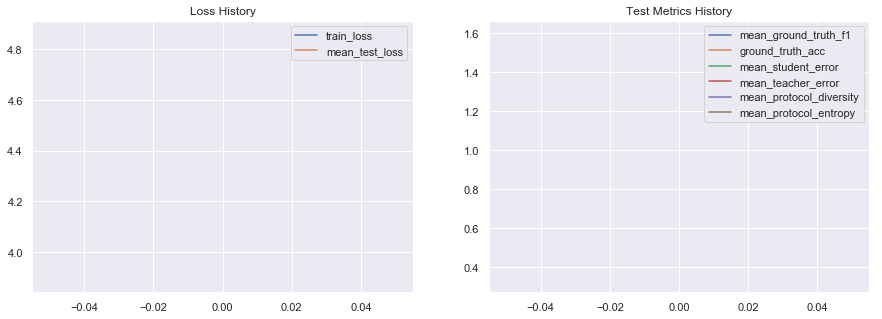

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax = axs[0]
ax.set_title('Loss History')
ax = axs[1]
ax.set_title('Test Metrics History')

ax = axs[0]
sns.lineplot(x=range(len(experiment.training_history)), 
             y=[item['loss'] for item in experiment.training_history],
             label='train_loss',
             ax=ax);

test_metric_items = [
    item['test_metrics'] 
    for item in experiment.training_history
    if 'test_metrics' in item
]
epochs = [
    epoch * experiment.test_freq 
    for epoch, item in enumerate(test_metric_items)
]
metrics = list(test_metric_items[0].keys())

for metric in metrics:
    ax = axs[1] if metric != 'mean_test_loss' else axs[0]
    sns.lineplot(x=epochs, 
                 y=[item[metric] for item in test_metric_items],
                 label=f'{metric}',
                 ax=ax)

In [23]:
experiment2 = create_self_play_experiment(epochs=100, p_mutate=0.3)

In [29]:
experiment2.run()

Running self_play_experiment...
Run config:
 {'name': 'self_play_experiment', 'max_epochs': 100, 'steps_per_epoch': 50, 'epochs_optimised': 51, 'play_params': {'channel_size': 5, 'p_mutate': 0.3}, 'test_freq': 5, 'test_steps': 25, 'optimiser_config': {'name': 'RMSprop', 'learning_rate': 0.009999999776482582, 'decay': 0.0, 'rho': 0.8999999761581421, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}, 'optimise_agents_separately': False, 'loss_fn': 'complete_loss_fn'}
Epoch 0, Time Taken (mm:ss): 0:9, Mean Loss: 3.783
Test Loss: 4.262, Ground Truth F1-Score: 0.35, Student Error: 1.104, Teacher Error: 0.761, Protocol Diversity: 0.461, Protocol Entropy: 0.838,
Epoch 1, Time Taken (mm:ss): 0:12, Mean Loss: 3.783
Epoch 2, Time Taken (mm:ss): 0:12, Mean Loss: 3.738
Epoch 3, Time Taken (mm:ss): 0:11, Mean Loss: 2.702
Epoch 4, Time Taken (mm:ss): 0:12, Mean Loss: 2.625
Epoch 5, Time Taken (mm:ss): 0:10, Mean Loss: 1.346
Test Loss: 1.348, Ground Truth F1-Score: 0.929, Student Error: 0.178, Te

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000243E246CF60>,
      dtype=object)

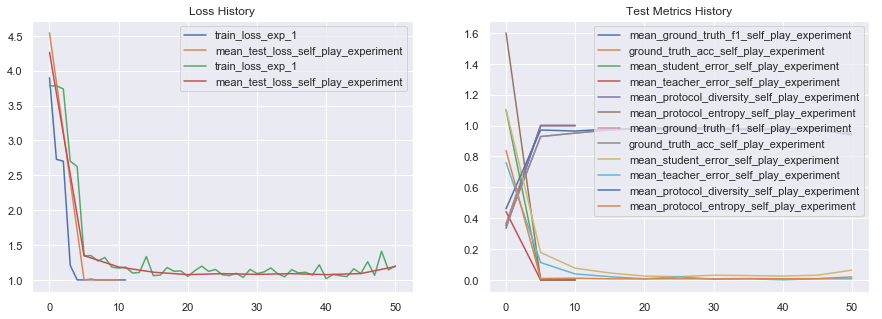

In [30]:
axs = experiment.plot_training_history()
experiment2.plot_training_history(axs=axs)

## Render Model Graph in Tensorboard

In [2]:
# # Set up logging.
# from datetime import datetime
# import tensorboard
# %load_ext tensorboard

# stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = f'logs\\{stamp}'
# writer = tf.summary.create_file_writer(logdir)

# # Bracket the function call with
# # tf.summary.trace_on() and tf.summary.trace_export().
# tf.summary.trace_off()
# tf.summary.trace_on(graph=True, profiler=True)
# # Call only one tf.function when tracing.

# @tf.function
# def graph_training_step():
#     return only_teacher_training_step(agent_1)

# graph_training_step()

# with writer.as_default():
#     tf.summary.trace_export(
#         name="teacher_only_training_step",
#         step=0,
#         profiler_outdir=logdir)
    
# tf.summary.trace_off()

In [3]:
# %tensorboard --logdir logs

## Analyse Trained Models

In [25]:
games_played, test_metrics = experiment.run_tests()
test_metrics

{'mean_test_loss': 1.0000001192092896,
 'mean_ground_truth_f1': 1.0,
 'ground_truth_acc': 1.0,
 'mean_student_error': 1.1920928955078125e-07,
 'mean_teacher_error': 1.1920928955078125e-07,
 'mean_protocol_diversity': 1.0,
 'mean_protocol_entropy': 7.222239013367687e-35}

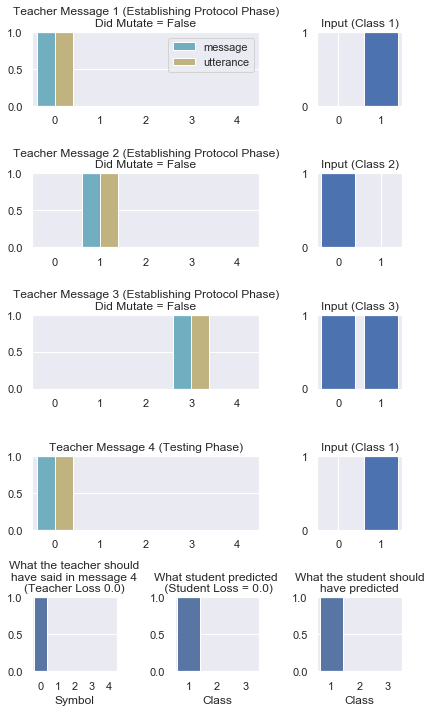

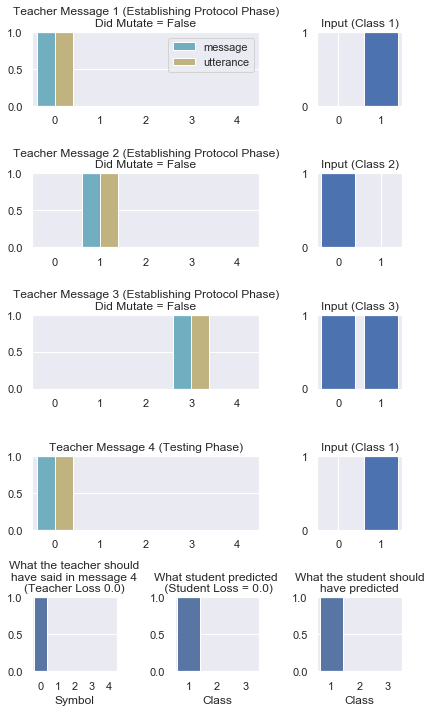

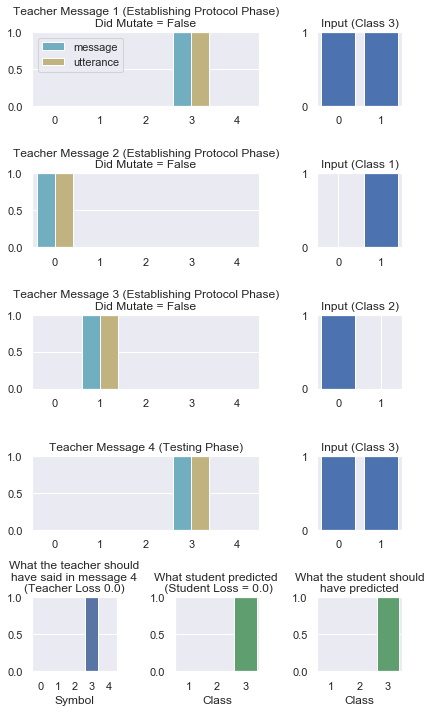

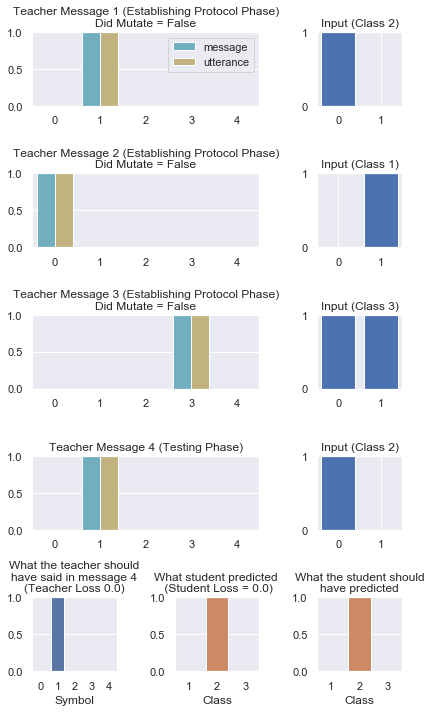

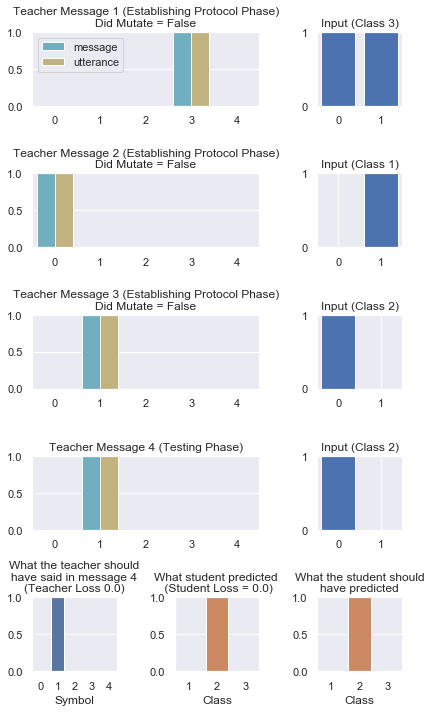

In [26]:
for i in range(5):
    inputs, targets, outputs = games_played[5+i]
    plot_game(inputs, outputs, targets, select_batch=0)

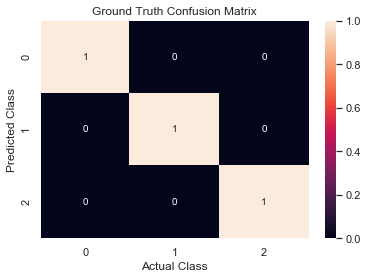

In [27]:
games_played, _ = experiment.run_tests()
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');

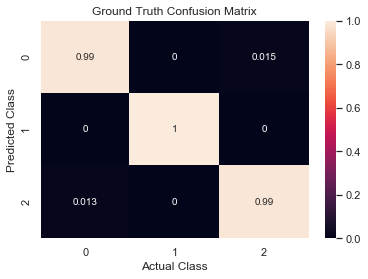

In [32]:
games_played, _ = experiment2.run_tests()
conf_matrix = compute_confusion_matrix(games_played)
sns.heatmap(conf_matrix, annot=True, vmin=0, vmax=1)
plt.title('Ground Truth Confusion Matrix')
plt.ylabel('Predicted Class')
plt.xlabel('Actual Class');

The rows correspond to the true labels and the columns to the predicted labels. Each column is divided by its sum in order to show the percentage of the time the model predicts the given class.

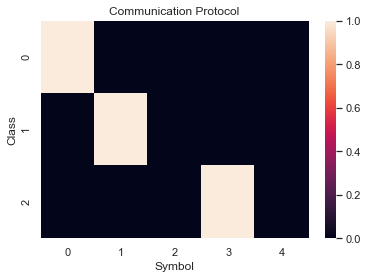

In [28]:
games_played, _ = experiment.run_tests()
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

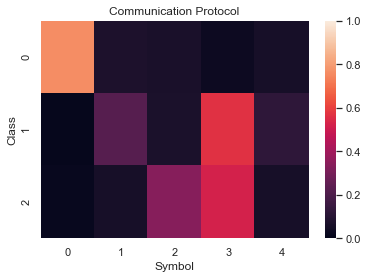

In [31]:
games_played, _ = experiment2.run_tests()
mean_class_message_map = create_mean_class_message_map(games_played)
sns.heatmap(mean_class_message_map, vmin=0, vmax=1);
plt.ylabel('Class')
plt.xlabel('Symbol')
plt.title('Communication Protocol')
plt.show()

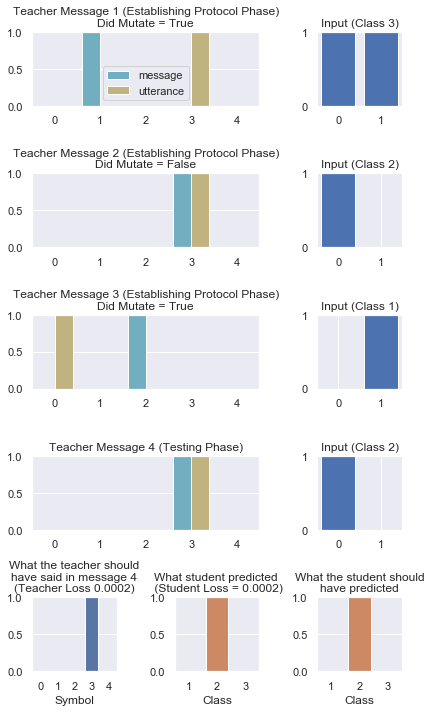

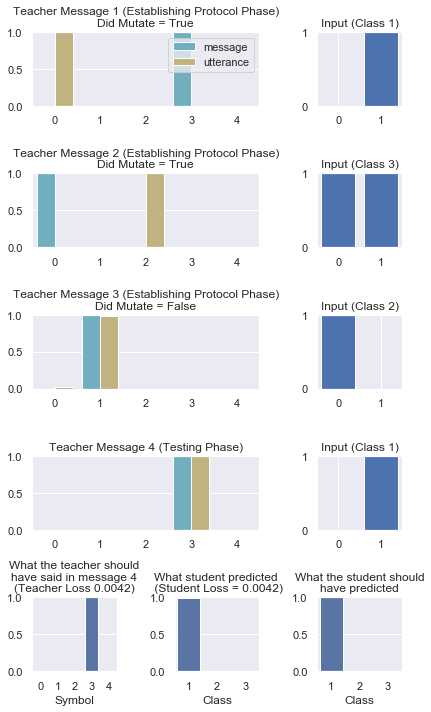

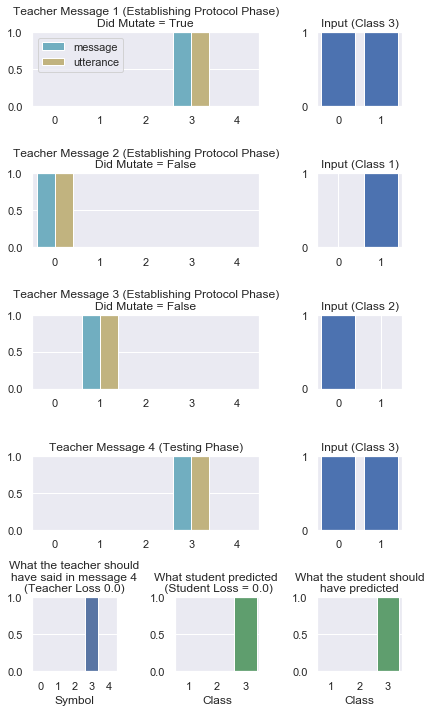

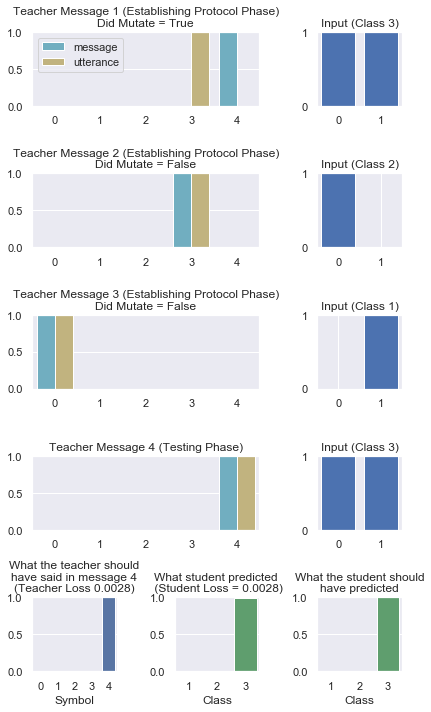

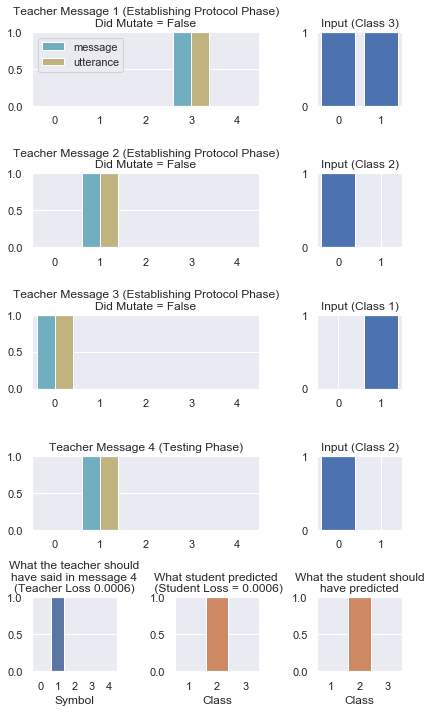

In [33]:
for i in range(5):
    inputs, targets, outputs = games_played[5+i]
    plot_game(inputs, outputs, targets, select_batch=1)

## Zero-shot Coordination

In [42]:
inputs, targets = generate_test_batch()
outputs = play_game(
    inputs, 
    experiment.teacher, 
    experiment2.student, 
    training=False, 
    p_mutate=0,
)

test_metrics = experiment.extract_test_metrics([(inputs, targets, outputs)])
experiment.print_test_metrics(test_metrics)

Test Loss: 1.0, Ground Truth F1-Score: 1.0, Student Error: 0.0, Teacher Error: 0.0, Protocol Diversity: 1.0, Protocol Entropy: 0.0,


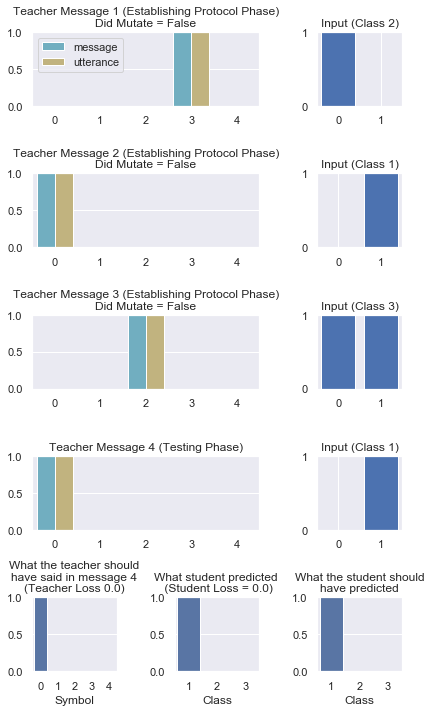

In [49]:
plot_game(inputs, outputs, targets, select_batch=0)

In [50]:
inputs, targets = generate_test_batch()
outputs = play_game(
    inputs, 
    experiment2.teacher, 
    experiment.student, 
    training=False, 
    p_mutate=0,
)

test_metrics = experiment.extract_test_metrics([(inputs, targets, outputs)])
experiment.print_test_metrics(test_metrics)

Test Loss: 4.074, Ground Truth F1-Score: 0.656, Student Error: 2.887, Teacher Error: 0.0, Protocol Diversity: 0.906, Protocol Entropy: 0.03,


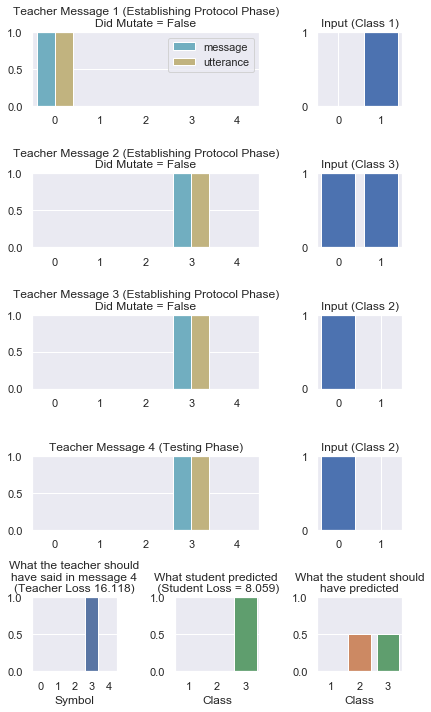

In [57]:
plot_game(inputs, outputs, targets, select_batch=4)

In [87]:
batch_size = 6
channel_size = 5

indices_col = []
for i in range(batch_size):
    idxs = list(range(channel_size))
    random.shuffle(idxs)

    indices_col.append(idxs)
indices_col = tf.convert_to_tensor(indices_col)

indices_row = tf.repeat([list(range(batch_size))], channel_size, axis=0)
indices_row = tf.transpose(indices_row)

permutation_map = tf.stack([indices_row, indices_col], axis=-1)
permutation_map

<tf.Tensor: shape=(6, 5, 2), dtype=int32, numpy=
array([[[0, 3],
        [0, 0],
        [0, 2],
        [0, 4],
        [0, 1]],

       [[1, 0],
        [1, 3],
        [1, 4],
        [1, 2],
        [1, 1]],

       [[2, 0],
        [2, 2],
        [2, 4],
        [2, 3],
        [2, 1]],

       [[3, 0],
        [3, 3],
        [3, 1],
        [3, 4],
        [3, 2]],

       [[4, 4],
        [4, 2],
        [4, 1],
        [4, 3],
        [4, 0]],

       [[5, 2],
        [5, 3],
        [5, 4],
        [5, 0],
        [5, 1]]])>

In [108]:
permutation_subset_size = 2

all_symbols = list(range(channel_size))
inputs = random.sample(all_symbols, permutation_subset_size)
outputs = inputs.copy()
random.shuffle(outputs)

mapping = all_symbols
for i, o in zip(inputs, outputs):
    mapping[i] = o

mapping


[0, 1, 2, 3, 4]

In [133]:
p_c = 0.0

In [134]:
round(p_c * channel_size, 0)

0.0

In [130]:
p_c * channel_size

3.5